# Vehicle Detection Project

The goals / steps of this project are the following:

* Train a HoG-based car classifier
* Implement a sliding window approach
* Reduce false positives and merge closeby detections
* Dispay results (test_images, project videos)
* Optional: Add advanced lane finding

---

---
# Train HoG-based car classifier

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import cv2
import glob
import time

import os
import pandas as pd

In [2]:
from util import read_images, convert_color, plotList

# Features

In [3]:
from features import prepare_train_test, get_hog_features, bin_spatial, color_hist, single_img_features, extract_features

## Dataset preparations

In [4]:
cars    = glob.glob('data/vehicles/**/*.png')
notcars = glob.glob('data/non-vehicles/**/*.png')

print('#cars    ', len(cars))
print('#notcars ', len(notcars))

# Reduce the sample size because HOG features are slow to compute
sample_size = -1
cars         = cars[0:sample_size]
notcars      = notcars[0:sample_size]

#def unison_shuffled_copies(a, b):
#    assert len(a) == len(b)
#    p = np.random.permutation(len(a))
#    return a[p], b[p]

cars_imgs    = read_images(cars)
notcars_imgs = read_images(notcars)

#cars     8792
#notcars  8968


### Plot a few dataset images

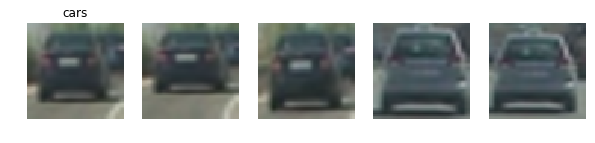

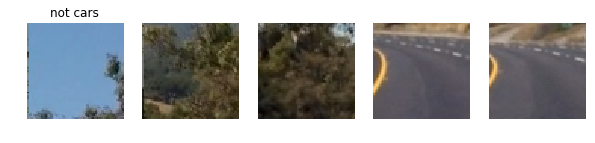

In [5]:
_ = plotList(cars_imgs,    titles=['cars'],     shape=(1,5), figsize=(10,2), plot_axis='off')
_ = plotList(notcars_imgs, titles=['not cars'], shape=(1,5), figsize=(10,2), plot_axis='off')

## Model training and parameter tuning

We start with the suggested initial parameters from the classroom.

By fixating most parameters and varying a small subset we can get a feeling for how these parameters behave.

In order to train a classifier we demonstrate the training pipeline.

In [6]:
from classifier import Classifier

In [7]:
config_initial = {
    'color_space':    'RGB',
    'hist_bins':      32,
    'spatial_size':   (32,32),
    'orient':         9,
    'hog_channel':    0,
    'pix_per_cell':   8,
    'cell_per_block': 2,
    'spatial_feat':   False,
    'hist_feat':      False,
    'hog_feat':       True
}
# feature vector length: 1764

In [8]:
### These are the tweaked parameters.

config_opt = {
    'color_space':    'HSV',    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    'hist_bins':      128,      # Number of histogram bins
    'spatial_size':   (8,8),    # Spatial binning dimensions
    'orient':         8,        # HOG orientations
    'hog_channel':    'ALL',    # Can be 0, 1, 2, or "ALL"
    'pix_per_cell':   16,       # HOG pixels per cell
    'cell_per_block': 4,        # HOG cells per block
    'spatial_feat':   False,    # Spatial features on or off
    'hist_feat':      False,    # Histogram features on or off
    'hog_feat':       True     # HOG features on or off
}
#feature vector length: 384

In [9]:
config_forums = {
    'color_space':    'RGB',
    'hist_bins':      32,
    'spatial_size':   (32,32),
    'orient':         11,
    'hog_channel':    'ALL',
    'pix_per_cell':   16,
    'cell_per_block': 2,
    'spatial_feat':   False,
    'hist_feat':      False,
    'hog_feat':       True
}
#feature vector length: 1188

In [10]:
config = config_opt

### Visualize features

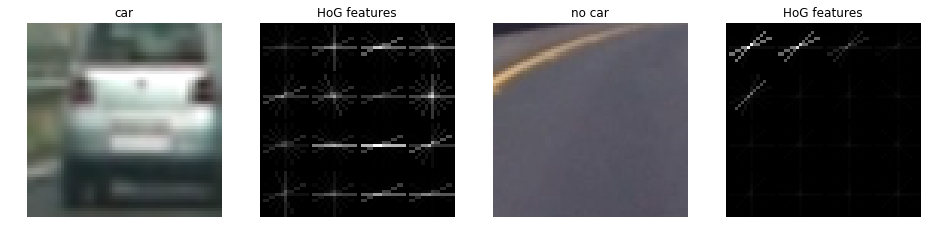

In [11]:
car_image    = cars_imgs[100]
ncar_image   = notcars_imgs[100]

_, hog1 = get_hog_features(car_image[:,:,2],  config['orient'], config['pix_per_cell'], config['cell_per_block'], vis=True, feature_vec=True)
_, hog2 = get_hog_features(ncar_image[:,:,2], config['orient'], config['pix_per_cell'], config['cell_per_block'], vis=True, feature_vec=True)

figure = plotList(
    [car_image,  hog1*255, ncar_image, hog2*255],
    titles=['car', 'HoG features', 'no car', 'HoG features'],
    shape=(1,4), figsize=(16,4), plot_axis='off',
    cmaps=['brg', 'gray', 'brg', 'gray']
)

figure.savefig('./examples/car_not_car.png')

## Train final classifier

In [12]:
X_scaler, X_train, X_test, y_train, y_test = prepare_train_test(config, cars_imgs, notcars_imgs)

print(y_test[0:10])  # should contain both classes
classifier, t_s = Classifier('nonlinear_svm').train(X_train, y_train)
accuracy = classifier.score(X_test, y_test)
print('feature vector length:', len(X_train[0]))
print('accuracy: {:.4f}'.format(accuracy))

[ 0.  1.  1.  1.  0.  0.  0.  0.  1.  1.]
feature vector length: 384
accuracy: 0.9803


---

# Sliding window object detector

In [18]:
from sliding_windows import slide_window, search_windows, draw_boxes, add_heat, apply_threshold, heatlabels, draw_labeled_bboxes, detect_raw, detect_at_scale

In [19]:
class FakeClassifier:
    def __init__(self):
        self.predict = lambda x: 1

always_true = FakeClassifier()

In [14]:
y_start_stop   = [400, 656] # Min and max in y to search in slide_window()

In [15]:
image = mpimg.imread('test_images/test3.jpg')

In [16]:
windows = slide_window(
    image,
    x_start_stop=[None, None],
    y_start_stop=y_start_stop,
    xy_window=(64, 64),
    xy_overlap=(0.75, 0.75)
)

Showing sliding window searches


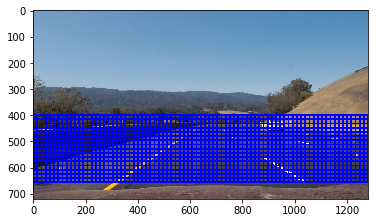

In [20]:
print('Showing sliding window searches')

hot_windows, window_img = detect_raw(image, windows, always_true, X_scaler, config, visualize=True)
plt.imshow(window_img)
_ = cv2.imwrite('examples/sliding_windows.jpg', cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR ))

Showing sliding window searches at different scale


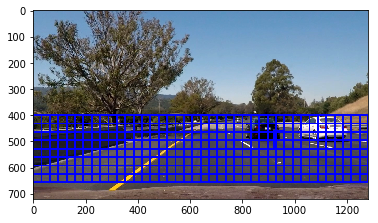

In [49]:
print('Showing sliding window searches at different scale')

hot_windows, window_img = detect_at_scale(image, always_true, scale=2.0, X_scaler=X_scaler, config=config_opt)

plt.imshow(window_img)
_ = cv2.imwrite('examples/sliding_windows2.jpg', cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR ))

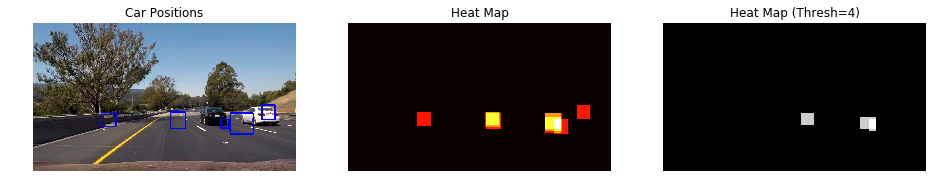

In [61]:
bboxes, heatmap, labels, draw_img = detect_at_multiple_scales(image, classifier, X_scaler, config, scales=[1.0, 1.1, 1.2, 1.3, 1.5, 1.75, 2.0], heat_thresh=1, visualize=True)
label_img = draw_labeled_bboxes(np.copy(image), labels)

heatmap4, labels = heatlabels(image, bboxes, heat_thresh=3)

fig = plotList(
    images = [draw_img, heatmap, heatmap4],
    titles = ['Car Positions', 'Heat Map', 'Heat Map (Thresh=4)'],
    shape = (1,3), figsize=(16,32), plot_axis='off',
    cmaps = ['brg', 'hot', 'gray']
)

fig.savefig('./examples/bboxes_and_heat.png')

Note: By integrating detections over multiple scales and setting a threshold of 4 we reduce the false positive rate!

In [52]:
def pipeline(image, heat_thresh):
    bboxes, heatmap, labels, draw_img = detect_at_multiple_scales(image, classifier, X_scaler, config, scales=[1.0, 1.1, 1.2, 1.3, 1.5, 1.75, 2.0], heat_thresh=heat_thresh, visualize=True)
    return draw_img

# Process Test Images

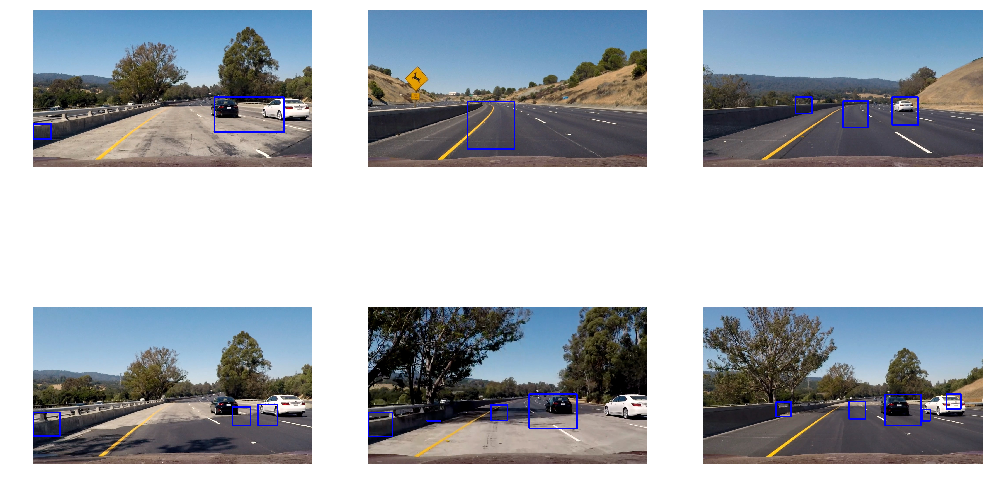

In [53]:
test_images = glob.glob('test_images/*.jpg')

processed = []
for image in read_images(test_images):
    processed.append( pipeline(image, 1) )

N = len(processed)

figure = plotList( processed, shape=(2,int(N/2)), figsize=(17,10), plot_axis='off' )
figure.savefig('examples/sliding_window.jpg')

outdir = 'output_images'
if not os.path.exists(outdir):
    os.mkdir(outdir)
for i, image in enumerate(processed):
    cv2.imwrite( os.path.join(outdir, os.path.splitext( os.path.basename( test_images[i] ) )[0] + '-raw.jpg'), cv2.cvtColor(image, cv2.COLOR_RGB2BGR) )

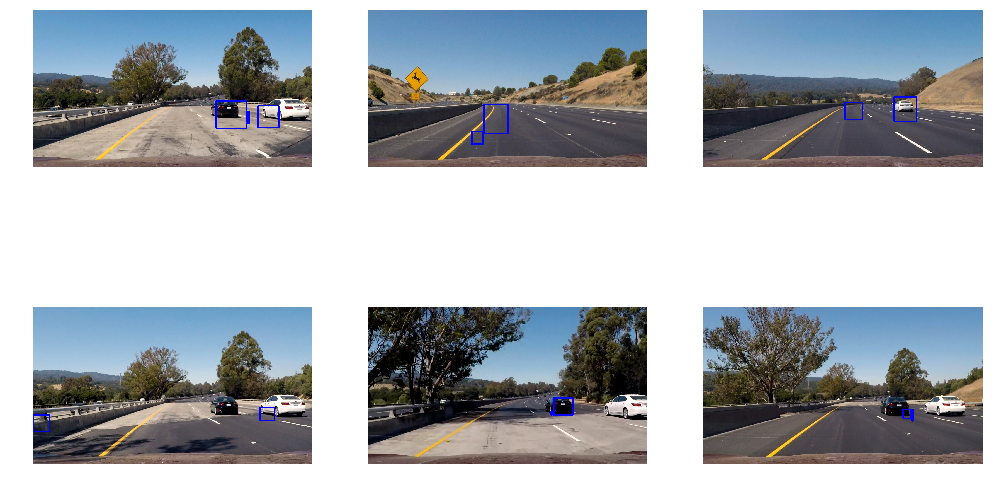

In [56]:
test_images = glob.glob('test_images/*.jpg')

processed = []
for image in read_images(test_images):
    processed.append( pipeline(image, 4) )

N = len(processed)
figure = plotList( processed, shape=(2,int(N/2)), figsize=(17,10), plot_axis='off' )
figure.savefig('examples/sliding_window2.jpg')

outdir = 'output_images'
if not os.path.exists(outdir):
    os.mkdir(outdir)
for i, image in enumerate(processed):
    cv2.imwrite( os.path.join(outdir, os.path.basename( test_images[i] )), cv2.cvtColor(image, cv2.COLOR_RGB2BGR) )

# Process Videos

In [57]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

from functools import partial

try:
    os.mkdir('test_videos_output')
except:
    pass

def processVideo(name, out, f_process):
    video = VideoFileClip(name)
    video_clip = video.fl_image(f_process) #NOTE: this function expects color images!!
    %time video_clip.write_videofile(out, audio=False)

process = partial(pipeline, heat_thresh=4)

In [58]:
processVideo("test_video.mp4", 'test_videos_output/test_video.mp4',process)
HTML("""
<video width="960" height="540" controls><source src="{0}"></video>
""".format('test_videos_output/test_video.mp4'))

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4



 97%|█████████▋| 38/39 [07:22<00:11, 11.48s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

CPU times: user 7min 21s, sys: 1.39 s, total: 7min 22s
Wall time: 7min 23s


In [59]:
processVideo("project_video.mp4", 'test_videos_output/project_video.mp4',process)
HTML("""
<video width="960" height="540" controls><source src="{0}"></video>
""".format('test_videos_output/project_video.mp4'))

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [4:01:47<00:11, 11.41s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 4h 1min 34s, sys: 30.1 s, total: 4h 2min 4s
Wall time: 4h 1min 48s


The algorithm has a lot of false positives. It especially seems to confuse yellow lanes for cars, possibly due to overfitting. I imagine a lot of "yellow" cars had been present and somehow this resulted in a classifier that would especially detect yellow edges. We could write out all detections of this video and manually train a new classifier from that data (hard negative mining).

---

---

---

---

---

---


# (IGNORE) HOG subsampling

Something wasn't working with the HoG subsampling, even after fixing the issue with hog_channel=='ALL'... So I did it the slow way instead.

In [20]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, classifier, X_scaler, config):
    
    color_space=config['color_space']
    spatial_size=config['spatial_size']
    hist_bins=config['hist_bins']
    orient=config['orient']
    pix_per_cell=config['pix_per_cell']
    cell_per_block=config['cell_per_block']
    hog_channel=config['hog_channel']
    spatial_feat=config['spatial_feat']
    hist_feat=config['hist_feat']
    hog_feat=config['hog_feat']
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else:
        ctrans_tosearch = np.copy(image)
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]
    
#    ch1 = ctrans_tosearch[:,:,0]
#    ch2 = ctrans_tosearch[:,:,1]
#    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_feat:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        if hog_channel == 'ALL':
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            feats = []
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            if hog_feat:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                if hog_channel == 'ALL':
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_features = hog_feat1
                feats.append(hog_features)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            
            if config['spatial_feat'] or config['hist_feat']:
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if config['spatial_feat']:
                spatial_features = bin_spatial(subimg, spatial_size)
                feats.append(spatial_features)
            if config['hist_feat']:
                hist_features = color_hist(subimg, hist_bins)
                feats.append(hist_features)
            
            test_features = X_scaler.transform( np.concatenate(feats).reshape(1,-1) )
            test_prediction = classifier.predict(test_features)
            
#            # Scale features and make a prediction
#            temp_test = np.concatenate((spatial_features, hist_features, hog_features))
#            #print("five ",temp_test.shape)
#            temp_test = temp_test.reshape(1, -1) 
#            test_features = X_scaler.transform(temp_test)    
#            #test_features = temp_test
#            test_prediction = classifier.predict(test_features)
            
            # Scale features and make a prediction
#            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
#            test_prediction = classifier.predict(test_features)


#            scaled_X = X_scaler.transform(hog_features.reshape(1, -1))
            #prediction = classifier.predict(scaled_X)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                upper_left, bottom_right = (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)
                boxes.append((upper_left, bottom_right))
    
    return draw_img, boxes